In [1]:
import copy
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import moment
from scipy.stats import tstd
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

# Load DataSet :

In [2]:
epsilon = 0.0000000000001

In [3]:
def load_data(set_type):
    if   set_type == 'BreastTissue':
        dataset = np.loadtxt('Datasets\BreastTissue.txt', delimiter = '\t', dtype='str')      
    elif set_type == 'Diabetes':
        dataset = np.loadtxt('Datasets\Diabetes.txt', delimiter = '\t', dtype='str')     
    elif set_type == 'Glass':
        dataset = np.loadtxt('Datasets\Glass.txt', delimiter = '\t', dtype='str')     
    elif set_type == 'Ionosphere':
        dataset = np.loadtxt('Datasets\Ionosphere.txt', delimiter = ',', dtype='str')     
    elif set_type == 'Sonar':
        dataset = np.loadtxt('Datasets\Sonar.txt', delimiter = ',', dtype='str')     
    elif set_type == 'Wine':
        dataset = np.loadtxt('Datasets\Wine.txt', delimiter = ', ', dtype='str')     
    
    n = dataset.shape[1]-1
    
    x = dataset[:,:n].astype(np.float)
    y = dataset[:,n].astype(np.int)
    
    y_unique = np.unique(y)
    k = len(np.unique(y))
    m = x.shape[0]          
    
    return x, y, m, k, n, y_unique

In [4]:
def normal(X):
    norm = copy.deepcopy(X)
    for i in range(0,X.shape[1]):
        min_ = np.min(X[:,i])
        max_ = np.max(X[:,i])
        norm[:,i] = (norm[:,i]-min_)/(max_ - min_ + epsilon)
    return norm

In [34]:
def plot_histogram(Normal, Anomalous, bins, title='Original Image'):    
    plt.title(title)
    plt.hist(Normal, bins=bins, range=(0,1), label='Normal', alpha=0.7)
    plt.hist(Anomalous, bins=bins, range=(0,1), label='Anomalous', alpha=0.7)
    plt.xlim([0, 1])  
    plt.legend(prop ={'size': 10})
    plt.show()

In [6]:
def print_dataset_specification(dataset, X, y, m, c, n, y_unique):
    print('---------------------------DataSet : '+ dataset +'---------------------------')
    print('x_train.shape =',X.shape)
    print('y_train.shape =',y.shape)
    print('m =',m)
    print('n =',n)
    print('c =',c)
    print('y_unique =',y_unique)   
    print('y = '+str(y_unique[0])+' is Inlier')   
    print('y = '+str(y_unique[1])+' is Outlier')   
    print('-----------------------------------------------------------------------------')
    print('')

In [7]:
dataset = 'Ionosphere'

In [8]:
X, y, m, c, n, y_unique = load_data(set_type=dataset)
print_dataset_specification(dataset, X, y, m, c, n, y_unique)  

---------------------------DataSet : Ionosphere---------------------------
x_train.shape = (351, 34)
y_train.shape = (351,)
m = 351
n = 34
c = 2
y_unique = [0 1]
y = 0 is Inlier
y = 1 is Outlier
-----------------------------------------------------------------------------



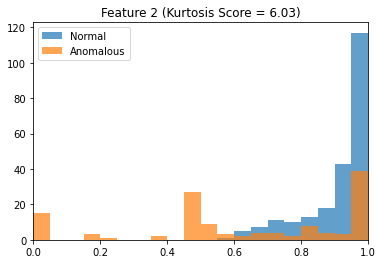

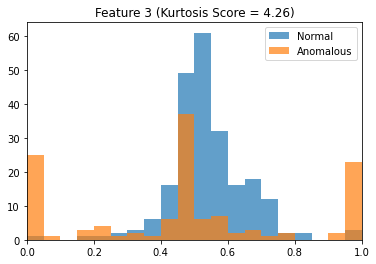

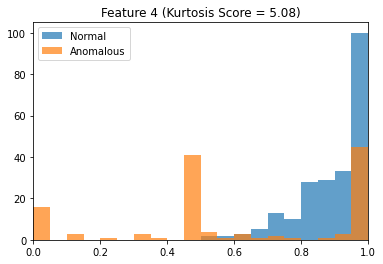

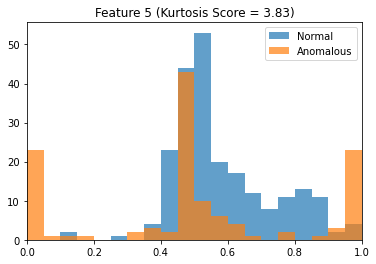

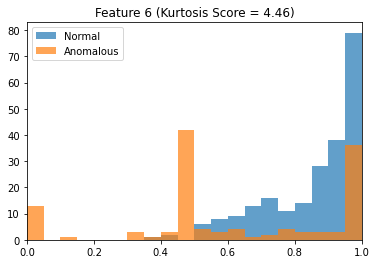

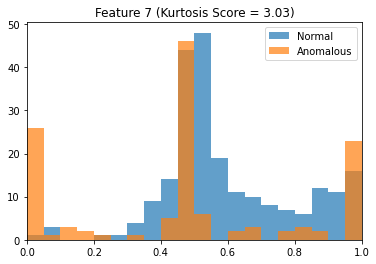

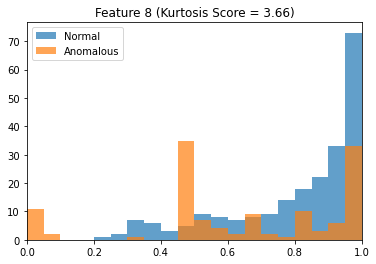

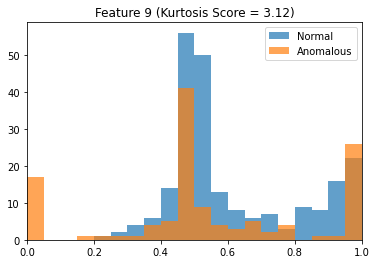

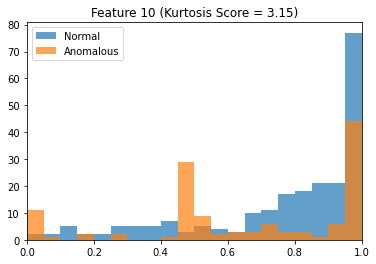

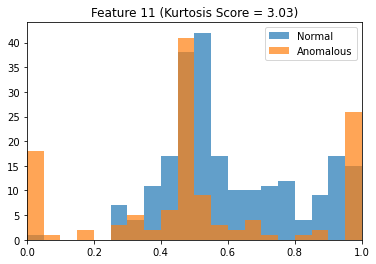

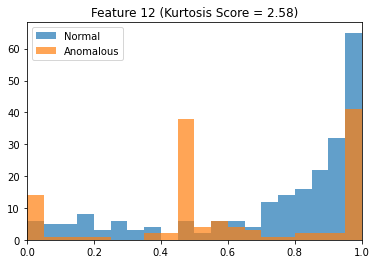

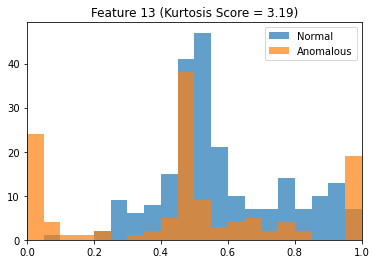

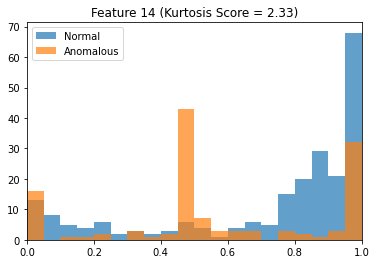

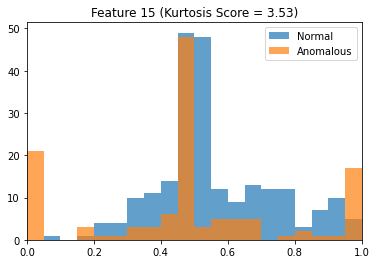

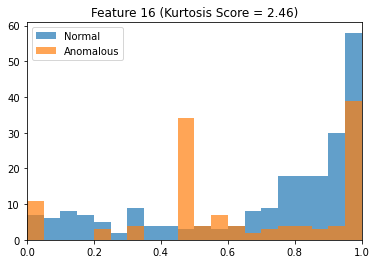

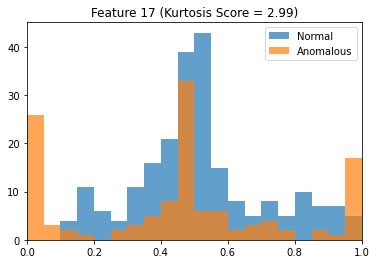

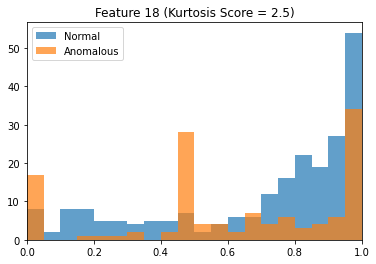

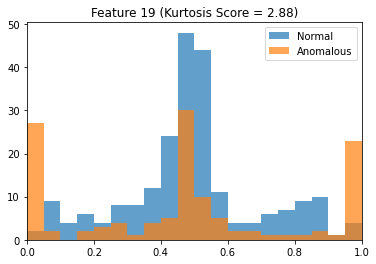

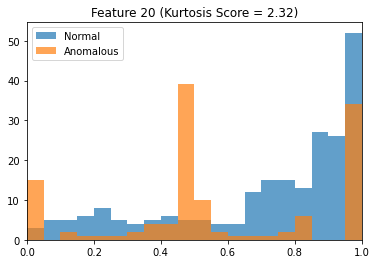

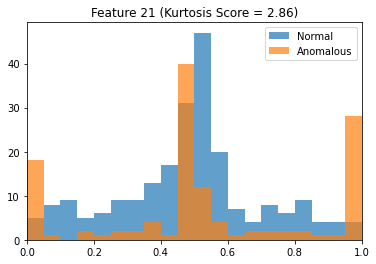

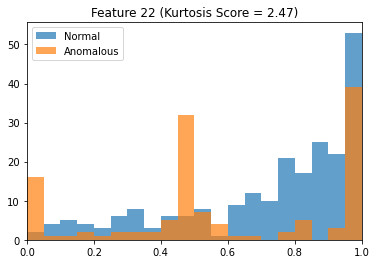

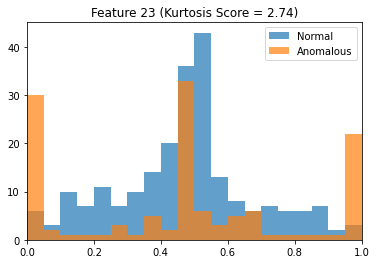

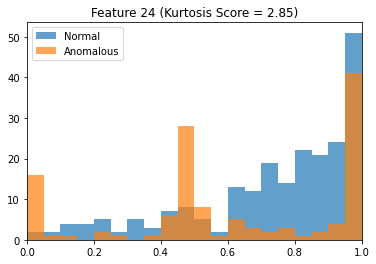

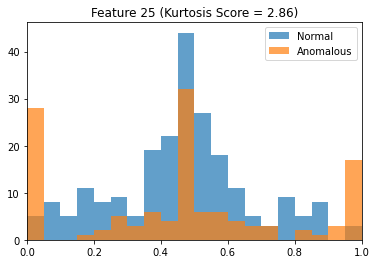

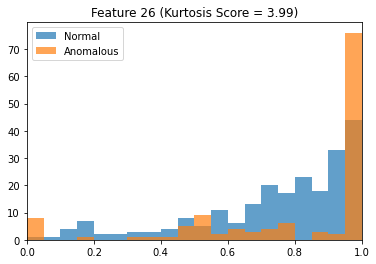

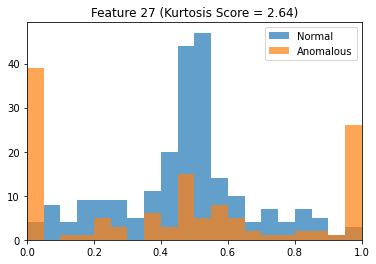

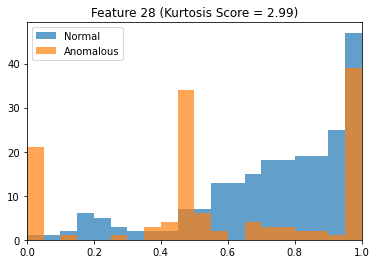

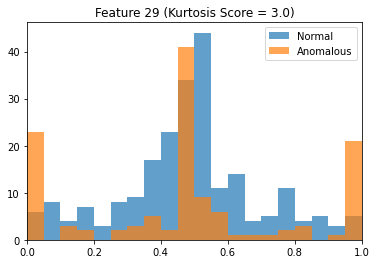

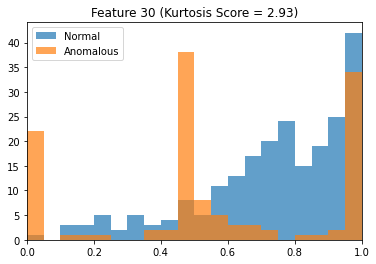

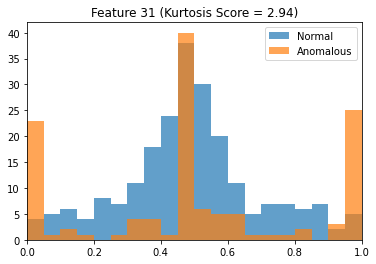

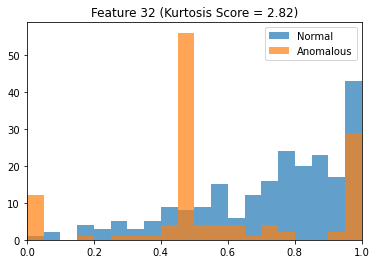

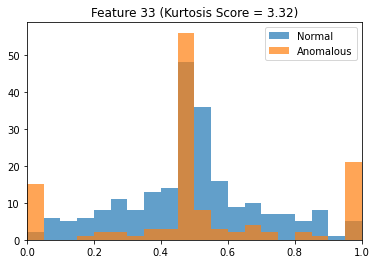

In [37]:
norm_ = normal(X)
inlier_samples = norm_[np.where(y==0)]
outlier_samples = norm_[np.where(y==1)]

K_s = np.round(kurtosis(X, axis=0, fisher=False, bias=True, nan_policy='propagate'),2)

for i in range(2, norm_.shape[1]):
    
    plot_histogram(inlier_samples[:,i], outlier_samples[:,i], bins=20, title='Feature '+str(i)+' (Kurtosis Score = '+str(K_s[i])+')')        
    

In [23]:
norm_[np.where(y==1)].shape

(126, 34)

# Algorithm RHF (Random Histogram Forest) :

In [10]:
class Node(object):
    def __init__(self):
        super(Node, self).__init__()        
        self.left = None
        self.right = None
        self.split_value = None
        self.split_feature = None
        self.attribute = None
        self.data = None
        self.depth = None
        self.size = None
        self.index = None
        self.type = 0
        self.parent = None

In [11]:
class Root(Node):
    def __init__(self):
        super().__init__()
        self.depth = 0
        self.index = 0

In [12]:
class RandomHistogramTree(object):
    def __init__(self, data = None, max_height = None):
        super(RandomHistogramTree, self).__init__()
        self.N = 0
        self.leaves = []
        self.max_height = max_height        

        if data is not None:
            self.build_tree(data)

    def generate_node(self, depth=None, parent=None):
        self.N += 1
        node = Node()
        node.depth = depth
        node.index = self.N
        node.parent = parent
        return node

    def set_leaf(self, node, data):
        node.type = 1
        node.size = data.shape[0]
        node.data_index = data.index
        self.leaves.append(node)

    def build(self, node, data):
        # node.data_index = data.index

        if data.shape[0] == 0:
            self.error_node = node
        if data.shape[0] <= 1 :
            self.set_leaf(node, data)
            return
        if data.duplicated().sum() == data.shape[0] - 1:
            self.set_leaf(node, data)
            return
        if node.depth >= self.max_height:
            self.set_leaf(node, data)
            return

        attribute, value = get_kurtosis_feature_split(data)

        node.left =  self.generate_node(depth = node.depth+1, parent = node)
        node.right = self.generate_node(depth = node.depth+1, parent = node)

        node.attribute = attribute
        node.value = value

        self.build(node.left, data[data[attribute] < value])
        self.build(node.right, data[data[attribute] >= value])

    def build_tree(self, data):
        self.tree_ = Root()
        self.build(self.tree_, data)

In [13]:
class RHF(object):
    def __init__(self, num_trees = 100, max_height = 5):
        super(RHF, self).__init__()
        self.num_trees  = num_trees
        self.max_height = max_height        

    def fit(self, data):
        data = pd.DataFrame(data)

        self.forest = []
        partial_scores = []
        scores = np.zeros(data.shape[0])
        self.uniques_ = data.shape[0]
        
        for tree_id in range(self.num_trees):

            randomHistogramTree = RandomHistogramTree(data=data, max_height=self.max_height)
            # self.forest.append(randomHistogramTree)

            for leaf in randomHistogramTree.leaves:
                samples_indexes = leaf.data_index
                p = leaf.size/self.uniques_
                scores[samples_indexes] += np.log(1/(p))
                    
        self.scores = scores
        return self.scores

In [14]:
def kurtosis_score(X):
    #kur = kurtosis(X, axis=0, fisher=False, bias=True, nan_policy='propagate')
    mu4 = moment(X, moment=4, axis=0, nan_policy='propagate')
    s = np.std(X, axis=0)
    kur = mu4/(np.power(s,4)+epsilon)
    
    return kur

In [15]:
def get_kurtosis_feature_split(X):
    
    # (5.1)
    K = kurtosis_score(X)
    #print('K =',K)

    # (5.2)
    K_sum = np.sum(np.log(K+1))
    #print('K_sum =',K_sum)

    while True:
    
        # (5.3)
        r = np.random.uniform(0, K_sum)
        #print('r =',r)

        # (5.4)
        cums = np.cumsum(np.log(K+1))
        a_s = np.digitize(x=r, bins=cums)
        #print('a_s =',a_s)

        # (6)
        f_min = np.min(X[a_s])
        f_max = np.max(X[a_s])
        a_v = np.random.uniform(f_min, f_max)
        if f_min < a_v < f_max:
            #print('a_v =',a_v)
            break        
            
    return a_s, a_v

In [18]:
num_trees = 100
max_height = 5

run_scores = []
run = 10
for i in range(0, run):
    my_rhf = RHF(num_trees = num_trees, max_height = max_height)
    scores = my_rhf.fit(X)/num_trees    
    #print(scores)
    #print(scores.argsort())
    run_scores.append(copy.deepcopy(scores))

In [40]:
print(run_scores[0])

[1.45386296 2.39378544 1.25689309 3.01196574 1.71076305 1.53897431
 2.15164112 3.39676512 1.79236842 2.0002943  2.00531194 2.7509092
 1.6062824  2.10817894 1.60790441 2.95481853 1.21735999 4.69306373
 1.58515013 4.05395743 1.45665955 3.92596173 1.10415578 3.88515693
 1.35492017 2.94195076 2.1164016  4.28061164 2.35235613 4.55731487
 1.80381929 2.90987201 1.62772015 2.23253945 1.84735868 2.63054337
 1.28493764 3.85074782 1.18267052 1.69419136 1.73738612 4.11592592
 1.74732828 3.40487302 1.71718726 3.3576292  1.48036584 2.71852748
 1.27975318 2.62591695 1.61541315 3.77798014 3.49733822 4.18875981
 1.47240361 4.01960374 1.63749518 4.23894725 1.44143228 3.22542026
 1.46448636 2.3167101  1.67026382 3.09856301 1.56189888 1.88283379
 1.31132569 3.2578852  2.72744285 2.92288294 1.76192646 4.06187387
 1.90431052 1.83236521 1.69619903 3.79417788 1.66848259 4.09981549
 3.0321198  3.81452937 2.10627933 3.22530507 1.78583991 1.72228758
 1.23347554 1.70720715 1.24212686 1.86004977 1.28129222 2.12632

# Evaluate :

In [41]:
run_ap = []
for i in range(0, run):
    ap = average_precision_score(y, run_scores[i])
    print('Run = '+str(i)+' --> Average Precision Score :'+str(ap))
    run_ap.append(ap)

print('')
ap_mean = np.mean(run_ap)
ap_std = np.std(run_ap)
print('Mean of '+str(run)+' Runs --> Average Precision Score :'+str(ap_mean))
print('STD of '+str(run)+' Runs --> Average Precision Score :'+str(ap_std))
print('')

Run = 0 --> Average Precision Score :0.8011630656066201
Run = 1 --> Average Precision Score :0.805583084007407
Run = 2 --> Average Precision Score :0.8058630558718594
Run = 3 --> Average Precision Score :0.8137809118067669
Run = 4 --> Average Precision Score :0.797966788171437
Run = 5 --> Average Precision Score :0.804028313224868
Run = 6 --> Average Precision Score :0.8160640391211081
Run = 7 --> Average Precision Score :0.8087560484487872
Run = 8 --> Average Precision Score :0.804004628601483
Run = 9 --> Average Precision Score :0.8225148973739984

Mean of 10 Runs --> Average Precision Score :0.8079724832234335
STD of 10 Runs --> Average Precision Score :0.007065750240697475

